In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import and_, func, inspect

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent

('2017-08-23')

In [11]:
# Calculate the date one year from the last date in data set.
one_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print('Query Date:', one_year)

Query Date: 2016-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Perform a query to retrieve the data and precipitation scores
date_prcp = engine.execute('SELECT date,prcp FROM Measurement').fetchall()
date_prcp
dateprcp_rows = [{"date": result[0], "prcp": result[1]} for result in date_prcp]

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(date_prcp, columns=["Date","Precipitation"])
prcp_df.set_index("Date", inplace=True,)
prcp_df.sort_values('Date')
prcp_df.head()

,Precipitation
Date,
2010-01-01,0.08
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-06,NaN


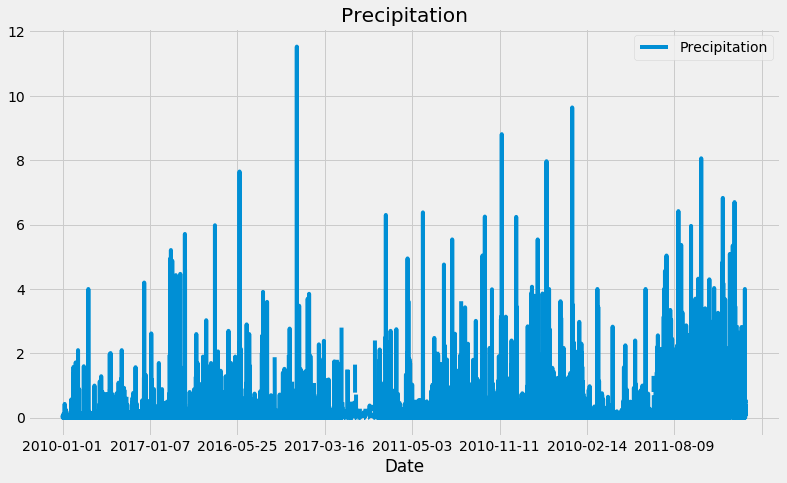

<Figure size 432x288 with 0 Axes>

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation", figsize=(12,7))
plt.show()
plt.savefig("images/Precipitation.png")

In [15]:
prcp_df.describe()

,Precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
average_prcp = prcp_df["Precipitation"].mean()
median_prcp = prcp_df["Precipitation"].median()
count_prcp = prcp_df["Precipitation"].count()
max_prcp = prcp_df["Precipitation"].max()
min_prcp = prcp_df["Precipitation"].min()

prcp_summary_df = pd.DataFrame({
    "Average Precipitation": [average_prcp],
    "Median Precipitation": [median_prcp],
    "Max Precipitation": [max_prcp],
    "Min Precipitation": [min_prcp],
    "Number of Entries": [count_prcp]
})
prcp_summary_df.head()

,Average Precipitation,Median Precipitation,Max Precipitation,Min Precipitation,Number of Entries
0,0.160644,0.01,11.53,0.0,18103


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [30]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tobs = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
summary_temp = session.query(*tobs).\
    filter(Measurement.station == "USC00519281").all()
# put data into a dataframe
summary_temp_df=pd.DataFrame(summary_temp, columns=["Min Temp","Max Temp", "Average Temp"])
summary_temp_df.head()

,Min Temp,Max Temp,Average Temp
0,54.0,85.0,71.663781


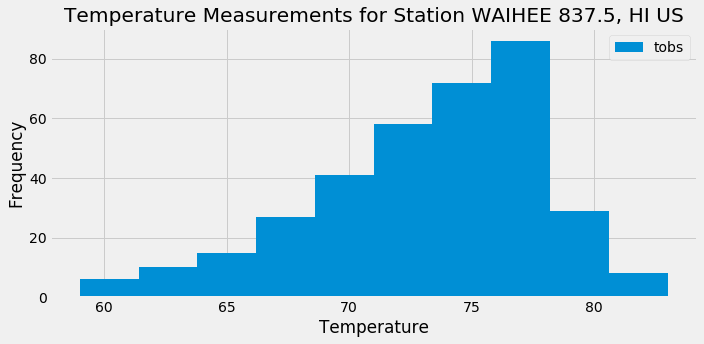

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
tobs_year = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()
#put into dataframe
tobs_year_df = pd.DataFrame(tobs_year, columns=['tobs'])
# plot the results as a histogram
tobs_year_df.plot.hist(figsize=(10,5), title = "Temperature Measurements for Station WAIHEE 837.5, HI US")
plt.xlabel("Temperature")
plt.tight_layout()
plt.savefig("images/temp_histogram.png")

# Close session

In [39]:
# Close Session
session.close()